TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'vol', 'vol10', 'vol15', 'vol30', 'vol60', 'volD10',
       'volD15', 'volD30', 'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30',
       'vpm60', 'ToD', 'DoW', 'MO'],
      dtype='object')
TESTING FOR: 
Dr3
X shape == (2800, 6, 31).
y shape == (2800,).
-0.004011168410071971
1.5208545801094329
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


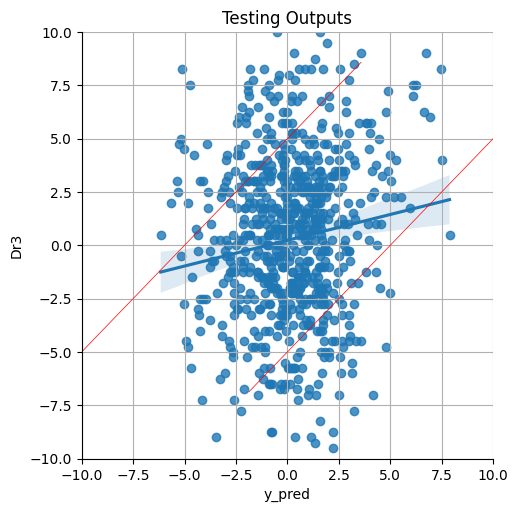

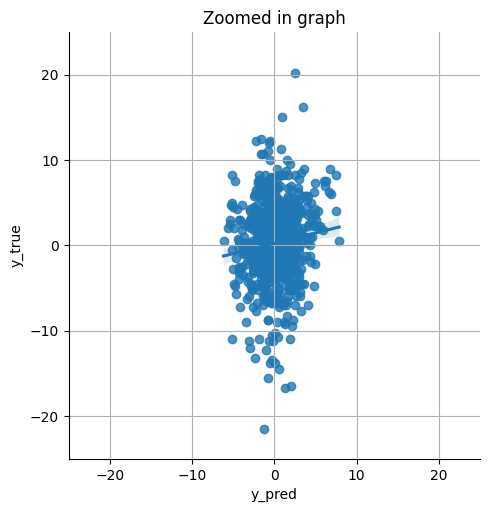

C:\Users\logan\AppData\Local\Temp\ipykernel_8716\1224856888.py:284: RuntimeWarning: divide by zero encountered in scalar divide
  sameTmp.append(abs(y_test[i])/(v/2))
C:\Users\logan\AppData\Local\Temp\ipykernel_8716\1224856888.py:287: RuntimeWarning: divide by zero encountered in scalar divide
  diffTmp.append(abs(y_test[i])/(v/2))
C:\Users\logan\AppData\Local\Temp\ipykernel_8716\1224856888.py:279: RuntimeWarning: divide by zero encountered in scalar divide
  diffTmp.append(abs(y_test[i])/(v/2))
C:\Users\logan\AppData\Local\Temp\ipykernel_8716\1224856888.py:276: RuntimeWarning: divide by zero encountered in scalar divide
  sameTmp.append(abs(y_test[i])/(v/2))


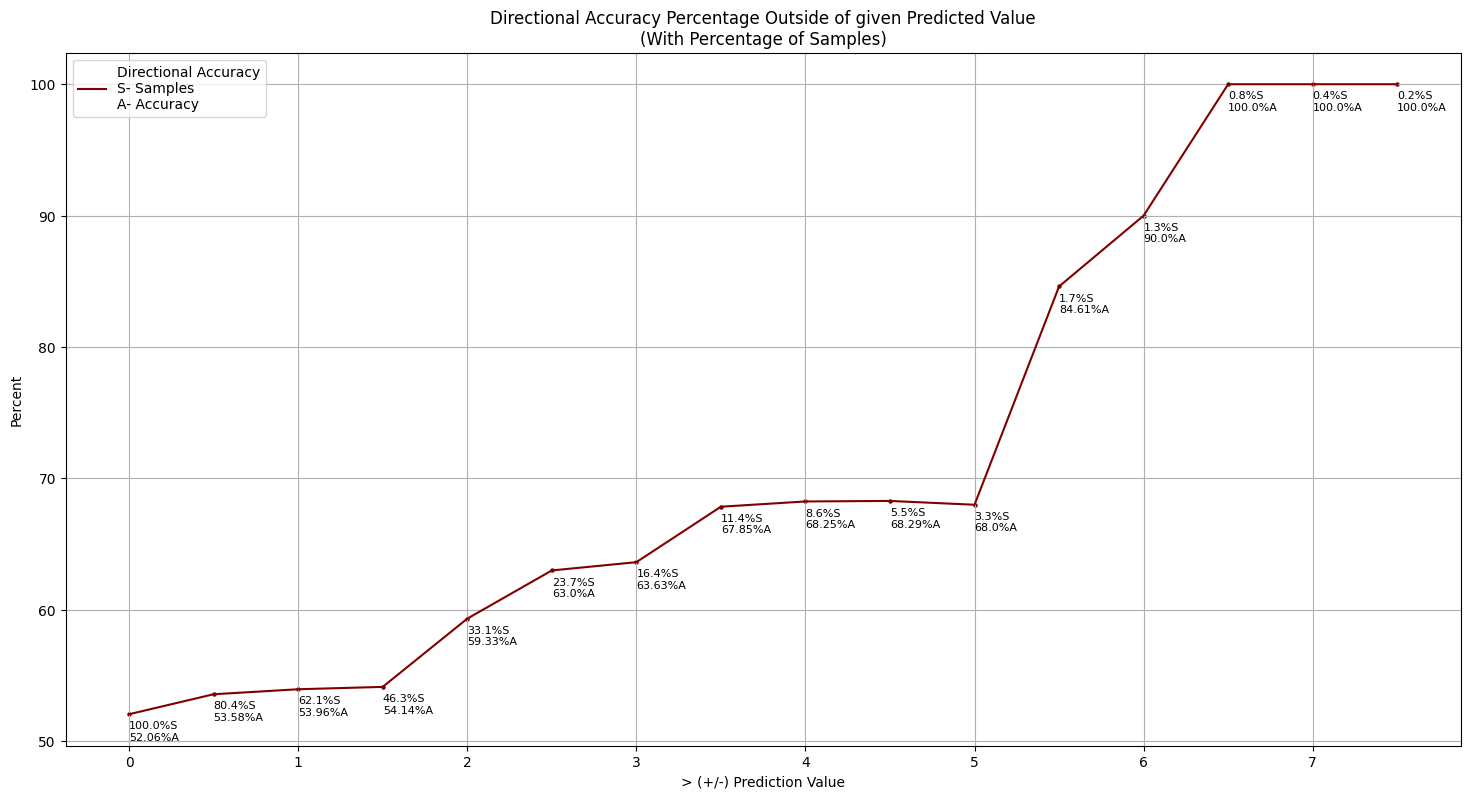

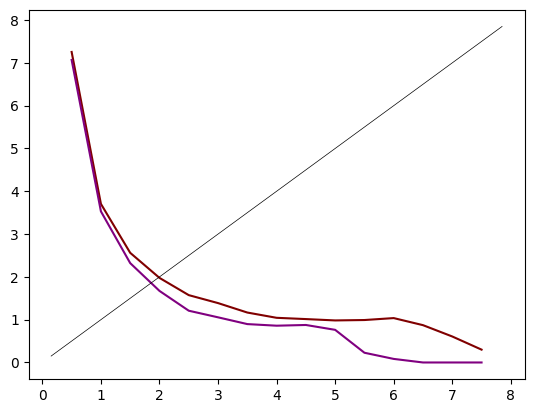

In [20]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_10day.csv')
dataTRAIN = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Dr3'
timeSteps = 6
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns='FT')
data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
dataTRAIN = dataTRAIN.drop(columns='FT')
dataTRAIN = dataTRAIN.drop(columns='FT.1')
dataTRAIN = dataTRAIN.drop(columns='FT.2')
dataTRAIN = dataTRAIN.drop(columns='YM_diff')
dataTRAIN = dataTRAIN.drop(columns='NQ_diff')
dataTRAIN = dataTRAIN.drop(columns='volNQdiff')
dataTRAIN = dataTRAIN.drop(columns='volYMdiff')
'''
data = data.drop(columns='vol60')
data = data.drop(columns='volD10')
data = data.drop(columns='volD15')
data = data.drop(columns='volD30')
data = data.drop(columns='volD60')
data = data.drop(columns='vpm5')
data = data.drop(columns='vpm10')
data = data.drop(columns='vpm15')
data = data.drop(columns='vpm30')
data = data.drop(columns='vpm60')
data = data.drop(columns='acc30')
data = data.drop(columns='acc60')
dataTRAIN = dataTRAIN.drop(columns='vol60')
dataTRAIN = dataTRAIN.drop(columns='volD10')
dataTRAIN = dataTRAIN.drop(columns='volD15')
dataTRAIN = dataTRAIN.drop(columns='volD30')
dataTRAIN = dataTRAIN.drop(columns='volD60')
dataTRAIN = dataTRAIN.drop(columns='vpm5')
dataTRAIN = dataTRAIN.drop(columns='vpm10')
dataTRAIN = dataTRAIN.drop(columns='vpm15')
dataTRAIN = dataTRAIN.drop(columns='vpm30')
dataTRAIN = dataTRAIN.drop(columns='vpm60')
dataTRAIN = dataTRAIN.drop(columns='acc30')
dataTRAIN = dataTRAIN.drop(columns='acc60')
'''

#CALENDAR
#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
dataTRAIN = dataTRAIN.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

XTRAIN = dataTRAIN.iloc[:, :-1].values
yTRAIN = dataTRAIN.iloc[:, -1].values

# Standardize the features
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = MinMaxScaler(feature_range=(-1,1))

percFit = 0.8
fitSplit = len(X)//(1/(percFit))
negFitSplit = len(X)//(1/(1-percFit))

scaler1.fit(XTRAIN)
XTRAIN = scaler1.transform(XTRAIN)
#scaler2.fit(XTRAIN)
#XTRAIN = scaler2.transform(XTRAIN)
#scaler3.fit(XTRAIN)
#XTRAIN = scaler3.transform(XTRAIN)
X = scaler1.transform(X)
#X = scaler2.transform(X)
#X = scaler3.transform(X)
#scaler3.fit(XTRAIN)


#X = scaler3.transform(X)

#setting data for LSTM
def reformat_to_lstm(X, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(X)):
        # Collect previous time_steps rows for X
        X_lstm.append(X[i-time_steps:i])  
        # The corresponding y value for the last time step in the sequence
    
    X_lstm = np.array(X_lstm)
    
    return X_lstm

X = reformat_to_lstm(X, timeSteps)
y = y[timeSteps:]
y = np.array(y)

XTRAIN = reformat_to_lstm(XTRAIN, timeSteps)
yTRAIN = yTRAIN[timeSteps:]
yTRAIN = np.array(yTRAIN)

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))


mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    non_zero_indices = (X[:, timeSteps-1, len(Xfeatures)-1] >= 0)
    # Filter X and y using these indices
    X_filtered = X[non_zero_indices]
    y_filtered = y[non_zero_indices]
    return X_filtered, y_filtered

def remove_extra_filter(X, y):
    
    indices = (X[:, timeSteps-1, len(Xfeatures)-3] >= -0.31415)#-3 is ToD, -pi/10 is open

    X_filtered = X[indices]
    y_filtered = y[indices]

    return X_filtered, y_filtered

X, y = remove_zero_mo_samples(X, y)
X, y = remove_extra_filter(X, y)
#XTRAIN, yTRAIN = remove_zero_mo_samples(XTRAIN, yTRAIN)

mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

loaded_model = tf.keras.models.load_model('LSTM_Dr3_6step_10.keras')
loaded_model.compile(optimizer='adam',
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])

#predicting the test set results
y_pred = loaded_model.predict(X) 

import seaborn as sns
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y})
#data.insert(1, "y_pred", y_pred, True)
# plot 1 with axes level-plot
g = sns.lmplot(data=ys,x="y_pred", y="y_true")#, hue="MO")

#plt.scatter(y_pred, y, s=1)
plt.axis('tight')
plt.grid()
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel(testFor)

# Get the current axes from the lmplot
ax = plt.gca()

# Define the limits for the line (should cover the same range as your plot)
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x

# Plot the y=x line
plt.plot(x_vals+5, y_vals, '-', color='red', label='y = x', linewidth=0.5)
plt.plot(x_vals-5, y_vals, '-', color='red', label='y = x', linewidth=0.5)

match tType:
    case 'D':
        plt.xlim(-10,10)
        plt.ylim(-10,10)
    case _:
        plt.xlim(0,5)
        plt.ylim(0,5)
plt.show()

g = sns.lmplot(data=ys,x="y_pred", y="y_true")#,hue="MO")
plt.title('Zoomed in graph')
plt.grid()
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.show()

#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
specGuess = 10
specAcc = []
valCount = []
sameDirAvg = []
diffDirAvg = []
for v in range(0,specGuess*2):
    tp, fp, tn, fn = 0, 0, 0, 0
    tp5, fp5, tn5, fn5 = 0, 0, 0, 0
    valCnt = 0
    sameTmp = []
    diffTmp = []
    y_pred = ys['y_pred']
    y_test = ys['y_true']
    for i in range(len(y_pred)):
        if(y_pred[i]>=(v/2)):
            valCnt+=1
            if(y_test[i]>0):
                tp5+=1
                sameTmp.append(abs(y_test[i])/(v/2))
            if(y_test[i]<0):
                fp5+=1
                diffTmp.append(abs(y_test[i])/(v/2))
        if(y_pred[i]<=-(v/2)):
            valCnt+=1
            if(y_test[i]<0):
                tn5+=1
                sameTmp.append(abs(y_test[i])/(v/2))
            if(y_test[i]>0):
                fn5+=1
                diffTmp.append(abs(y_test[i])/(v/2))
    if((tp5+fp5+tn5+fn5)<1):
        break

    if(len(sameTmp)!=0):
        sameDirAvg.append(np.average(sameTmp))
    else:
        sameDirAvg.append(0)
    if(len(diffTmp)!=0):
        diffDirAvg.append(np.average(diffTmp))
    else:
        diffDirAvg.append(0)
    directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
    specAcc.append(directionalAccuracy5guess)
    valCount.append(valCnt)
    #print(f'Directional Accuracy >(+/-){v/2}:\t',directionalAccuracy5guess)
#print('Directional Accuracy:\t\t',directionalAccuracy)
valCount = [x / valCount[0] * 100 for x in valCount]
plt.figure(figsize=(18, 9))
plt.plot(np.arange(0,0.5*len(specAcc),0.5), specAcc, 'maroon', label='Directional Accuracy')
plt.scatter(np.arange(0,0.5*len(specAcc),0.5), specAcc, s=5, color='maroon')
#plt.plot(np.arange(0,0.5*len(specAcc),0.5), valCount, 'r', label='% Of Samples')
plt.title('Directional Accuracy Percentage Outside of given Predicted Value\n(With Percentage of Samples)')
plt.xlabel('> (+/-) Prediction Value')
plt.ylabel('Percent')
plt.grid()
plt.legend(['Directional Accuracy\nS- Samples\nA- Accuracy'], loc='upper left')
for x, y in zip(np.arange(0,0.5*len(specAcc),0.5), specAcc):
    plt.annotate(f'{float(valCount[int(x*2)]*10//1/10)}%S\n{float(specAcc[int(x*2)])}%A', color='black', xy=(x, y-2), fontsize=8)
plt.show()

plt.plot(np.arange(0.5,0.5*len(specAcc),0.5), sameDirAvg[1:], 'maroon', label='Directional Accuracy')
plt.plot(np.arange(0.5,0.5*len(specAcc),0.5), diffDirAvg[1:], 'purple', label='Directional Accuracy')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x

# Plot the y=x line
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.show()

In [ ]:
data.corr()
#print(X.shape)

In [6]:
for i in range(len(y_pred)):
    check = i
    newSet = X[check:check+1]
    newTest = loaded_model.predict(newSet, verbose=0)
    #print(newSet[-1][5])
    invNorm = scaler1.inverse_transform(newSet[-1])
    #print(invNorm[5][28])
    if (newTest[0][0]>=6.5 or newTest[0][0]<=-6.5):
        print('\nNEW\n')
        print(newTest)
        invNorm = scaler1.inverse_transform(newSet[-1])
        print(invNorm[5])


NEW

[[7.484265]]
[-8.26000000e-02 -5.87000000e-02 -2.61000000e-02  7.30000000e-03
 -1.70000000e-02 -4.79000000e-02 -9.79000000e-02 -6.68000000e-02
  4.85000000e-02  8.60000000e-03  3.47368000e+01  1.61000000e-02
 -9.94500000e-01 -4.66330000e+00  1.55680000e+04  1.17110000e+04
  1.13776667e+04  1.05508333e+04  1.37315000e+04  3.29348000e+01
  3.68295000e+01  4.75523000e+01  1.33744000e+01 -3.00000000e-04
 -3.00000000e-04 -1.00000000e-04  0.00000000e+00 -1.00000000e-04
  9.30000000e+02  1.00000000e+00  1.00000000e+00]

NEW

[[6.927319]]
[ 4.40000000e-03 -3.91000000e-02 -3.77000000e-02 -1.30000000e-02
 -1.52000000e-02  8.70000000e-02 -4.13000000e-02 -4.93000000e-02
  4.30000000e-03  1.15000000e-02  3.57895000e+01  4.32800000e-01
  1.56080000e+00  2.55530000e+00  1.20760000e+04  1.38220000e+04
  1.18326667e+04  1.06713333e+04  1.33190833e+04 -1.26320000e+01
  2.05650000e+00  1.31630000e+01 -9.33310000e+00  0.00000000e+00
 -2.00000000e-04 -2.00000000e-04 -1.00000000e-04 -1.00000000e-04
  